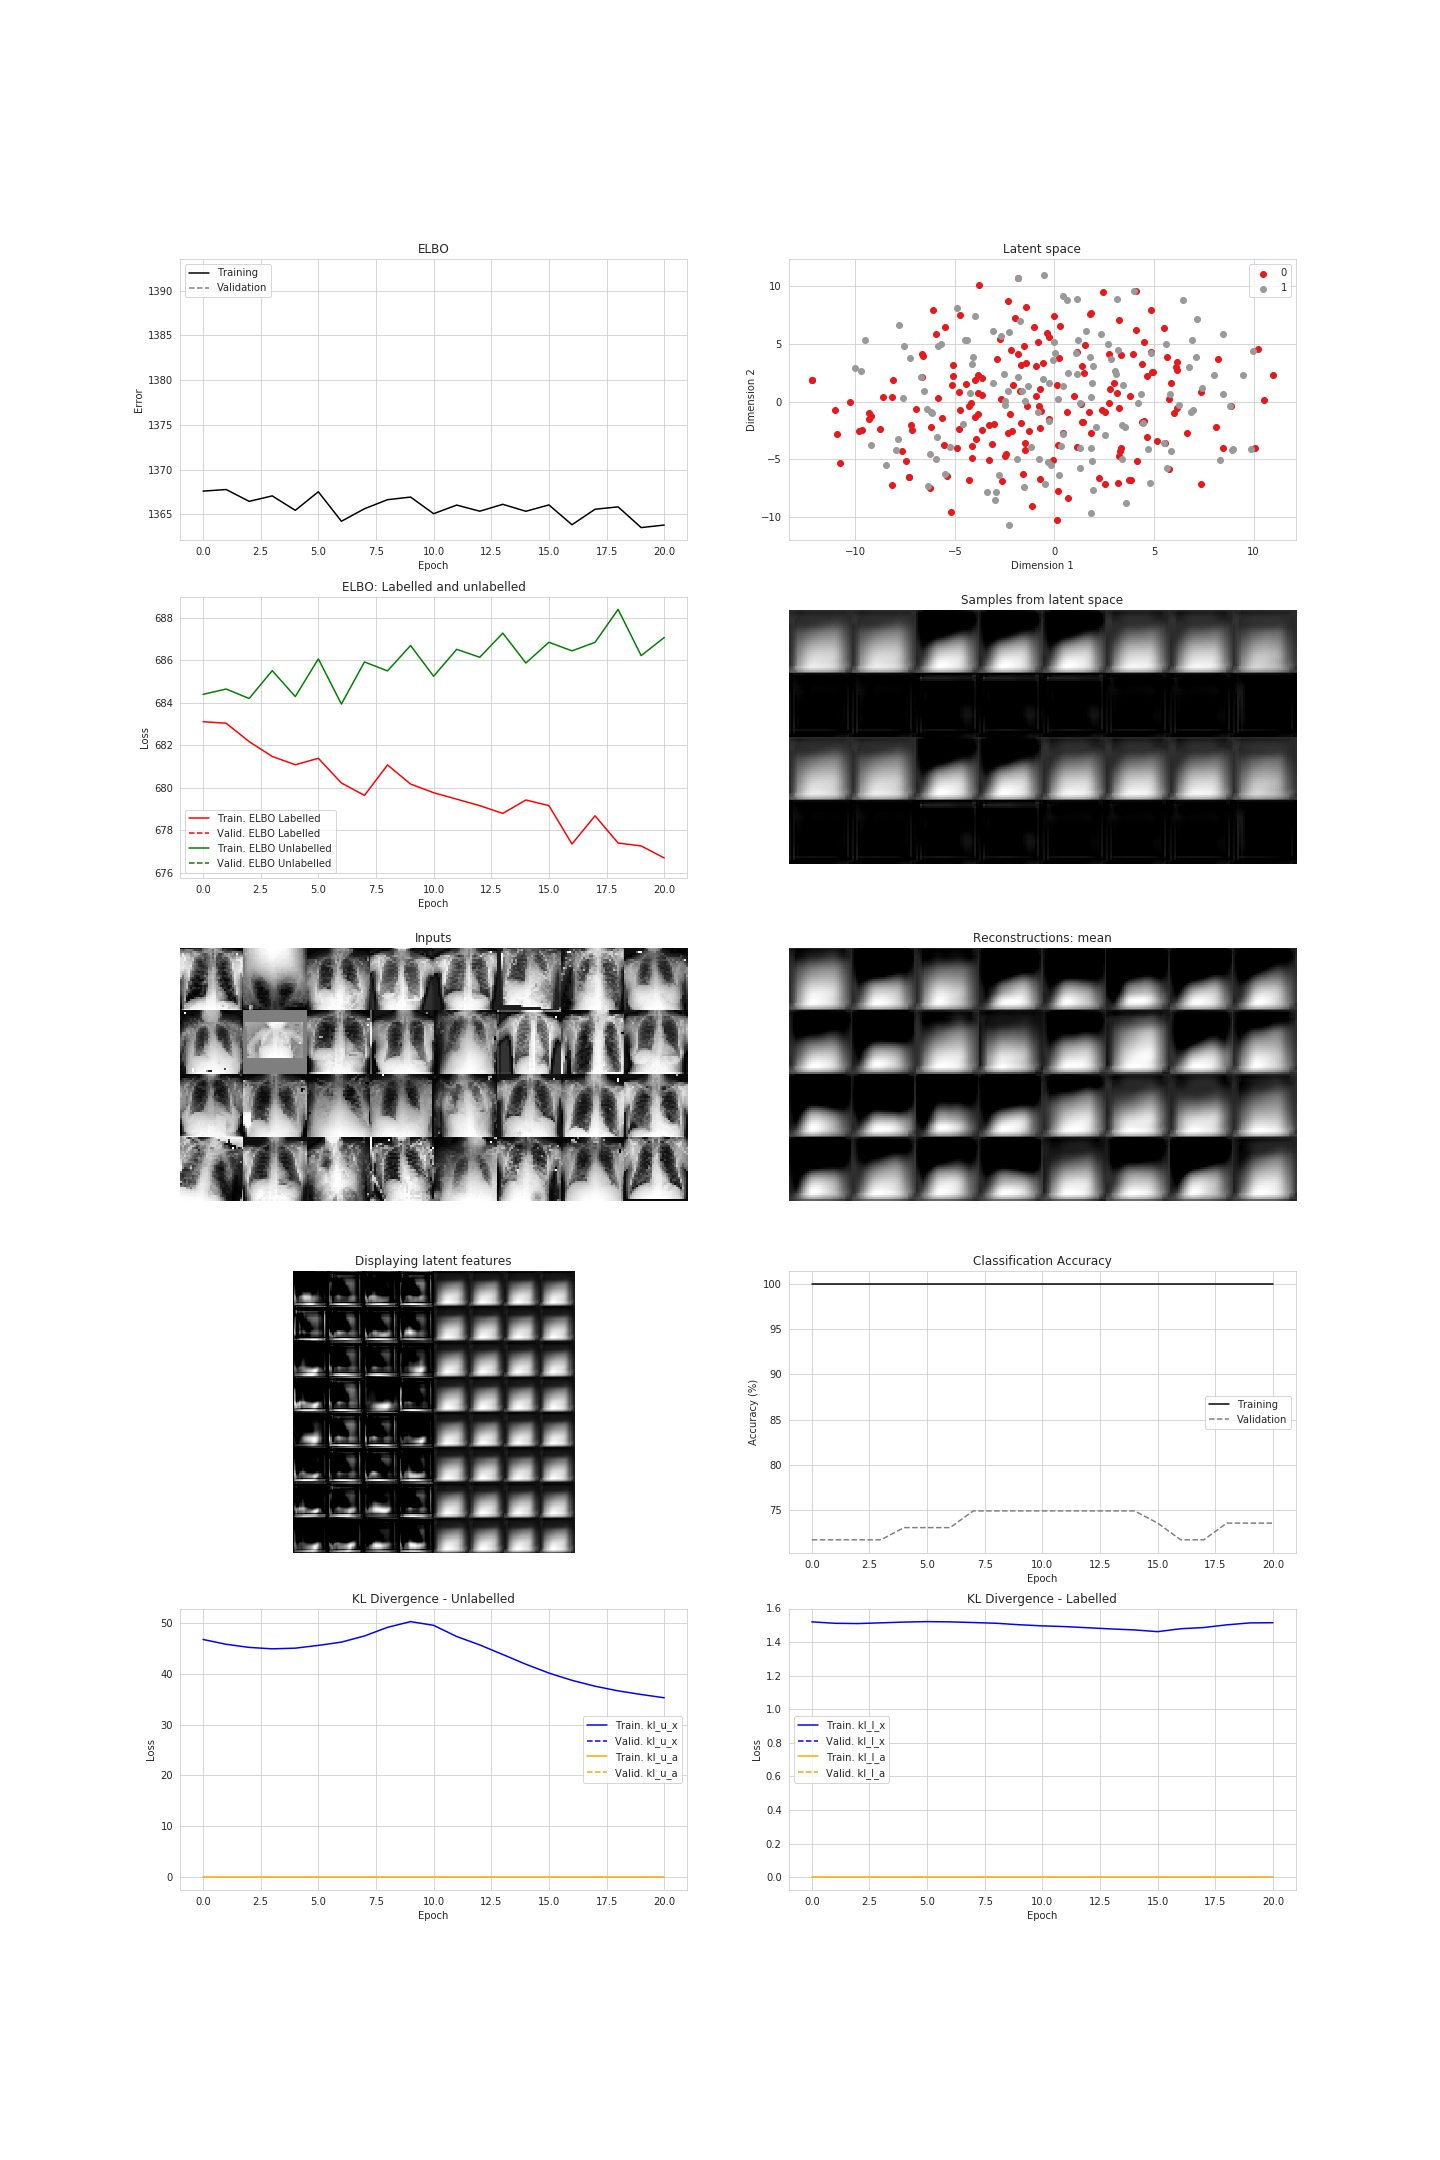

Acc:  tensor(0.7352)
TP:  tensor(135.)
FP:  tensor(35.)
TN:  tensor(100.)
FN:  tensor(50.)
P:  tensor(185.)
N:  tensor(135.)


In [95]:
#### Train network ####

torch.cuda.empty_cache
# Deleting variable Image and reload package Image
%reset_selective -f "^Image$"
from IPython.display import Image
from sklearn.manifold import TSNE
import sys


import os
from sklearn.decomposition import PCA

 
batch_epo_u = No_samples_train // batch_size
batch_epo_l = No_samples_train_labelled // batch_size
batch_per_epoch = batch_epo_u if batch_epo_u>batch_epo_l else batch_epo_l


tmp_img = "tmp_vae_out.png"
show_sampling_points = False
classes = [0,1]

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []
train_likelihood, valid_likelihood = [], []
train_classification, valid_classification = [], []
train_acc, valid_acc = [], []
train_L, train_H, train_kl_u_x, train_kl_u_a, train_elbo_l, train_kl_l_x, train_kl_l_a = [], [], [], [], [], [], []
valid_L, valid_H, valid_kl_u_x, valid_kl_u_a, valid_elbo_l, valid_kl_l_x, valid_kl_l_a = [], [], [], [], [], [], []
# train_latent_loss, valid_latent_loss = [], []
total_loss = []



device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)


for epoch in range(num_epochs):
    batch_loss, batch_kl, batch_likelihood, batch_acc, batch_classification = [], [], [], [], []
    batch_L, batch_H, batch_kl_u_x, batch_kl_u_a, batch_elbo_l, batch_kl_l_x, batch_kl_l_a = [], [], [], [], [], [], []
#     batch_latent_loss = []
    net.train()
    
    # Deterministic Warmup for KL divergence
    #kl_warmup = 1
    if epoch >= deterministic_increment:
        kl_warmup = 1
    else:
        kl_warmup = epoch * 1/deterministic_increment            
    print("KL Warm-Up: ", kl_warmup)
    ###############################
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    count = 0
    total_loss_batch = 0
    for (x, y), (u, _) in zip(cycle(train_loader_labelled), train_loader):
        y_hot =  torch.zeros([batch_size,2])
        for i in range(len(y)):
            y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])
            
        x, y, u, y_hot = Variable(x), Variable(y), Variable(u), Variable(y_hot)
        if cuda:
            # They need to be on the same device and be synchronized.
            x, y, y_hot = x.cuda(device=0), y.cuda(device=0), y_hot.cuda(device=0)
            u = u.cuda(device=0)

        count = count + 1
        if not count % (batch_per_epoch/4):
            print("Epoch:", epoch, "Batch:", count,"/",batch_per_epoch)

        #### Unlabelled
        outputs = net(u)
        elbo_u, elbo_H, elbo_L, kl_u, likelihood_u, kl_u_x, kl_u_a = loss_function(u, outputs, kl_warmup)
        elbo_H = elbo_H.cpu().detach().numpy()
        elbo_L = elbo_L.cpu().detach().numpy()
        kl_u_x = kl_u_x.cpu().detach().numpy()
        kl_u_a = kl_u_a.cpu().detach().numpy()
        
        #### Labelled
        outputs = net(x,y_hot)
        logits = outputs["y_hat"]
        y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
        
        # Weight the classification loss for the two classes
        classification_loss =  alpha * balanced_binary_cross_entropy( logits, y_hot)
        acc = balanced_accuracy( logits, y_hot)
        batch_acc.append(100*acc)
        elbo_l, kl_l, likelihood_l, kl_l_x, kl_l_a = loss_function(x, outputs, kl_warmup)
        kl_l_x = kl_l_x.cpu().detach().numpy()
        kl_l_a = kl_l_a.cpu().detach().numpy()
        
        #### Latent lose
#         rho = torch.tensor(0.05)
#         act = outputs["activation"]
#         act = (act-torch.min(act)) / torch.max(act-torch.min(act))
#         # Mean over batches (training set): from [batch_size, num_samples, num_hidden_units] -> [num_samples, num_hidden_units]
#         rho_hat = torch.mean(torch.abs(act), dim = 0)
#         # Sum over num_samples and num_hidden_units
#         latent_loss = beta * torch.torch.sum(torch.abs(rho * torch.log( rho / rho_hat ) 
#                                           + (1 - rho) * torch.log( (1-rho) / (1-rho_hat)))).cuda(device=0)

        
        ### Combine losses 
        loss =  elbo_l + elbo_u + classification_loss #+ latent_loss # notice alpha has been moved to where classification loss is calculated
        total_loss_batch += loss.item()
        
        ### Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        elbo_l = elbo_l.cpu().detach().numpy()
        batch_classification.append(classification_loss.item())
        batch_loss.append(loss.item())
        batch_kl.append(kl_u.item()+kl_l.item())
        batch_likelihood.append(likelihood_u.item() + likelihood_l.item())
        batch_L.append(elbo_L) # NOT elbo_l, but L from elbo_u
        batch_H.append(elbo_H)
        batch_kl_u_x.append(kl_u_x)
        batch_kl_u_a.append(kl_u_a)
        batch_elbo_l.append(elbo_l)
        batch_kl_l_x.append(kl_l_x)
        batch_kl_l_a.append(kl_l_a)
#         latent_loss = latent_loss.cpu().detach().numpy()
#         batch_latent_loss.append(latent_loss)
    
    train_classification.append(np.mean(batch_classification))
    train_acc.append(np.mean(batch_acc))    
    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))
    train_likelihood.append(np.mean(batch_likelihood))
    total_loss.append(total_loss_batch / (batch_size*batch_per_epoch))
    train_L.append(np.mean(batch_L))
    train_H.append(np.mean(batch_H))
    train_kl_u_x.append(np.mean(batch_kl_u_x))
    train_kl_u_a.append(np.mean(batch_kl_u_a))
    train_elbo_l.append(np.mean(batch_elbo_l))
    train_kl_l_x.append(np.mean(batch_kl_l_x))
    train_kl_l_a.append(np.mean(batch_kl_l_a))
#     train_latent_loss.append(np.mean(batch_latent_loss))
    
    
    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        
        y_hot =  torch.zeros([batch_size,2])
        for i in range(len(y)):
            y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])
        x, y, y_hot = Variable(x), Variable(y), Variable(y_hot)
        if cuda:
            # They need to be on the same device and be synchronized.
            x, y_hot = x.cuda(device=0), y_hot.cuda(device=0)
        
        #### Unlabelled
        outputs = net(u)
        elbo_u, elbo_H, elbo_L, kl_u, likelihood_u, kl_u_x, kl_u_a = loss_function(u, outputs, kl_warmup)
        elbo_H = elbo_H.cpu().detach().numpy()
        elbo_L = elbo_L.cpu().detach().numpy()
        kl_u_x = kl_u_x.cpu().detach().numpy()
        kl_u_a = kl_u_a.cpu().detach().numpy()
        
        #### Labelled
        outputs = net(x,y_hot)
        x_hat = outputs['x_hat']
        logits = outputs["y_hat"]
        z = outputs["z"]
        
        y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
        #acc = torch.sum(y_hot.view(-1,2) * logits.view(-1,2), dim = 1).cpu().detach().numpy()
        #valid_acc.append(sum(acc > 0.5) / batch_size*num_samples)
        acc = balanced_accuracy( logits, y_hot)
        valid_acc.append(100*acc)
        
        # Weight the classification loss for the two classes
        #classWeight = torch.FloatTensor([torch.sum(y_hot[:,1,0])/torch.sum(y_hot[:,1,]), torch.sum(y_hot[:,1,1])/torch.sum(y_hot[:,1,])]).cuda(device=0)
        #classification_loss = alpha*torch.nn.functional.binary_cross_entropy(logits,y_hot, weight=classWeight)
        #classification_loss = torch.sum(torch.abs(y_hot - logits))
        #classification_loss = alpha*torch.nn.functional.binary_cross_entropy(logits,y_hot)
        classification_loss = alpha * balanced_binary_cross_entropy( logits, y_hot)
        # elbo, kl = loss_function(x_hat, x, mu, log_var)
        elbo_l, kl_l, likelihood_l, kl_l_x, kl_l_a = loss_function(x, outputs, kl_warmup)
        kl_l_x = kl_l_x.cpu().detach().numpy()
        kl_l_a = kl_l_a.cpu().detach().numpy()
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
        
    
        valid_classification.append(classification_loss.item())
        valid_loss.append(elbo_l.item()+classification_loss.item()+elbo_u.item())
        valid_kl.append(kl_l.item())
        valid_likelihood.append(likelihood_l.item())
        valid_L.append(elbo_L)
        valid_H.append(elbo_H)
        valid_kl_u_x.append(kl_u_x)
        valid_kl_u_a.append(kl_u_a)
        valid_elbo_l.append(elbo_l.item())
        valid_kl_l_x.append(kl_l_x)
        valid_kl_l_a.append(kl_l_a)
        
    
    if epoch == 0:
        continue
    
    if epoch % min(print_every, num_epochs-1):
        continue
    
    validation_from = min(validation_every, num_epochs-1)
    if epoch < validation_from:
        VALIDATION = False
    else:
        VALIDATION = True
    
    # -- Plotting --
    f, axarr = plt.subplots(5, 2, figsize=(20, 30))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    if VALIDATION:
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_loss[validation_from:len(valid_loss)], color="gray", linestyle="--")
        ax.legend(['Training', 'Validation'])
    else:
        ax.legend(['Training'])
        
        
    # Latent space
    ax = axarr[0, 1]
    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    if batch_size > 4:
        rows = 4
        columns = batch_size // rows if batch_size // rows < 8 else 8            
    else:
        rows = 2
        columns = 2
    
    span = np.linspace(-4, 4, rows)
    grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)
    
    # If you want to use a dimensionality reduction method you can use
    # for example PCA by projecting on two principal dimensions

    """ PCA """
    #z = PCA(n_components=2).fit_transform(z.reshape(-1,latent_features))
    #z = z.reshape(batch_size,num_samples,2)
    
    """ TSNE """
    z = TSNE(n_components=2).fit_transform(z.reshape(-1,latent_features))
    z = z.reshape(batch_size,num_samples,2)
    #z = z[:,1,] # We do only want to plot one z instead of |num_samples|
    
    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
    if show_sampling_points:
        ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

    ax.legend()
    
    # KL / reconstruction
    ax = axarr[1, 0]
    
    ax.set_title("Losses")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax.set_title("ELBO: Labelled and unlabelled")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')        
    if VALIDATION:
        ax.plot(np.arange(epoch+1), train_elbo_l, color="red")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_elbo_l[validation_from:len(valid_loss)], color="red", linestyle="--")
        ax.plot(np.arange(epoch+1), train_L, color="green")  
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_L[validation_from:len(valid_loss)], color="green", linestyle="--") 
        ax.legend(['Train. ELBO Labelled',  'Valid. ELBO Labelled', 'Train. ELBO Unlabelled', 'Valid. ELBO Unlabelled'])
    else:
        ax.plot(np.arange(epoch+1), train_elbo_l, color="red")
        ax.plot(np.arange(epoch+1), train_L, color="green")    # Typically L >>> H, therefore not L+H   
        ax.legend(['Train. ELBO Labelled', 'Train. ELBO Unlabelled'])
    
    # Latent space samples
    ax = axarr[1, 1]
    ax.set_title('Samples from latent space')
    ax.axis('off')

    with torch.no_grad():
        epsilon = torch.randn(batch_size, latent_features).to(device)
        samples = torch.sigmoid(net.sample_from_latent(epsilon)).cpu().detach().numpy()

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = samples[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = samples[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Inputs
    ax = axarr[2, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = x[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[2, 1]
    ax.set_title('Reconstructions: mean')
    ax.axis('off')

    canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            #temp_img = x_hat[idx].reshape((224, 224))
            #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = normalize_2(x_hat[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE)))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[3, 0]
    ax.axis('off')
    #ax.set_title('Reconstructions: sigma')
    #sigma = (torch.exp(outputs["x_log_var"]/2)).detach().to("cpu").numpy()
    #canvas = np.zeros((IMG_SIZE*rows, columns*IMG_SIZE))
    #for i in range(rows):
    #    for j in range(columns):
    #        idx = i % columns + rows * j
    #        #temp_img = x_hat[idx].reshape((224, 224))
    #        #canvas[i*28:(i+1)*28, j*28:(j+1)*28] = resize(temp_img, output_shape=[28,28], mode='reflect', anti_aliasing=True)
    #        canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = sigma[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE))
    #ax.imshow(canvas, cmap='gray')
    ax.set_title('Displaying latent features')
    with torch.no_grad():
        latent_feature = torch.zeros(batch_size,latent_features).to(device)
        for i in range(0,latent_features if latent_features<= batch_size else batch_size):
            latent_feature[i,i] = 100
        displaying_latent_features = (net.sample_from_latent(latent_feature)).cpu().detach() #no sigmoid, instead normalize later
        
    if displaying_latent_features.shape[0] == 64: 
        rows_2 = 8
        columns_2 = 8
    elif displaying_latent_features.shape[0] == 128: 
        rows_2 = 8
        columns_2 = 16
    else:
        rows_2 = rows
        columns_2 = columns   
    canvas = np.zeros((IMG_SIZE*rows_2, columns_2*IMG_SIZE))  
    for i in range(rows_2):
        for j in range(columns_2):
            idx = i % columns_2 + rows_2 * j
            canvas[i*IMG_SIZE:(i+1)*IMG_SIZE, j*IMG_SIZE:(j+1)*IMG_SIZE] = normalize_2(displaying_latent_features[idx,0:IMG_SIZE**2].reshape((IMG_SIZE, IMG_SIZE)))
    ax.imshow(canvas, cmap='gray')
    
                
    # Classification Loss
    ax = axarr[3, 1]
    ax.set_title("Classification Accuracy")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    
    ax.plot(np.arange(epoch+1), train_acc, color="black")
    ax.plot(np.arange(epoch+1), valid_acc, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    # KL Divergence - Unlabelled
    ax = axarr[4,0]
    ax.set_title("KL Divergence - Unlabelled")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if VALIDATION:
        ax.plot(np.arange(epoch+1), train_kl_u_x, color="blue")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_kl_u_x[validation_from:len(valid_loss)], color="blue", linestyle="--")
        ax.plot(np.arange(epoch+1), train_kl_u_a, color="orange")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_kl_u_a[validation_from:len(valid_loss)], color="orange", linestyle="--")
        ax.legend(['Train. kl_u_x',  'Valid. kl_u_x', 'Train. kl_u_a', 'Valid. kl_u_a'])
    else:
        ax.plot(np.arange(epoch+1), train_kl_u_x, color="blue")
        ax.plot(np.arange(epoch+1), train_kl_u_a, color="orange")
        ax.legend(['Train. kl_u_x',  'Train. kl_u_a'])

    # KL Divergence - Labelled
    ax = axarr[4,1]
    ax.set_title("KL Divergence - Labelled")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if VALIDATION:
        ax.plot(np.arange(epoch+1), train_kl_l_x, color="blue")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_kl_l_x[validation_from:len(valid_loss)], color="blue", linestyle="--")
        ax.plot(np.arange(epoch+1), train_kl_l_a, color="orange")
        ax.plot(np.arange(epoch+1)[validation_from:len(valid_loss)], valid_kl_l_a[validation_from:len(valid_loss)], color="orange", linestyle="--")
        #ax.plot(np.arange(epoch+1), train_latent_loss, color="green")
        ax.legend(['Train. kl_l_x',   'Valid. kl_l_x', 'Train. kl_l_a', 'Valid. kl_l_a'])
        #ax.legend(['Train. kl_l_x',   'Valid. kl_l_x', 'Train. kl_l_a', 'Valid. kl_l_a', 'Latent_loss'])
    else:
        ax.plot(np.arange(epoch+1), train_kl_l_x, color="blue")
        ax.plot(np.arange(epoch+1), train_kl_l_a, color="orange")
        #ax.plot(np.arange(epoch+1), train_latent_loss, color="green")
        ax.legend(['Train. kl_l_x',  'Train. kl_l_a'])
        #ax.legend(['Train. kl_l_x',  'Train. kl_l_a',  'Latent_loss'])
    
    clear_output(wait=True)
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))

    os.remove(tmp_img)
    
    if epoch % 20:
        continue
    
    # Run trough full test data set
    TP, FP, FN, TN, P, N = 0, 0, 0, 0, 0, 0
    for (x, y) in test_loader:
        y_hot =  torch.zeros([batch_size,2])

        for i in range(len(y)):
            y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])
        x, y, y_hot = Variable(x), Variable(y), Variable(y_hot)
        if cuda:
            # Must be synchronized on the same device
            x, y_hot = x.cuda(device=0), y_hot.cuda(device=0)

        #### Labelled
        outputs = net(x,y_hot)
        logits = outputs["y_hat"]
        y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
        acc_1, TP_1, FP_1, FN_1, TN_1, P_1, N_1 = balanced_accuracy_test(logits, y_hot)
        TP += TP_1
        FP += FP_1
        FN += FN_1
        TN += TN_1
        P  += P_1
        N  += N_1

    acc =  torch.sum(TP/P + TN/N)/2  
    print("Acc: ",acc)    
    print("TP: ",TP)
    print("FP: ",FP)
    print("TN: ",TN)
    print("FN: ",FN)
    print("P: ",P)
    print("N: ",N)